In [1]:
# # clone the respective repository
!git clone https://github.com/sathishkumar67/Feature-Fusion.git

# move the files to the current directory
!mv /kaggle/working/Feature-Fusion/* /kaggle/working/ # replace /content/ in the place of /kaggle/working/ if you are using Google Colab

# upgrade pip
!pip install --upgrade pip

# install the required packages
!pip install -r requirements.txt --upgrade --upgrade-strategy eager -q # if needed remove -q to disable quiet mode

Cloning into 'Feature-Fusion'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 18 (delta 6), reused 12 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (18/18), 5.27 KiB | 1.76 MiB/s, done.
Resolving deltas: 100% (6/6), done.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 12.2 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 80.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 55.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 140.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 103.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 6.4 MB/s eta 0:00:000:00:01
   ━━━━━━

In [2]:
# import os
# import shutil

# # Get the current working directory
# current_path = os.getcwd()

# # Loop through all items in the directory
# for item in os.listdir(current_path):
#     item_path = os.path.join(current_path, item)

#     try:
#         if os.path.isfile(item_path) or os.path.islink(item_path):
#             os.remove(item_path)  # Remove files and symbolic links
#         elif os.path.isdir(item_path):
#             shutil.rmtree(item_path)  # Remove directories
#     except Exception as e:
#         print(f"Failed to delete {item_path}. Reason: {e}")

In [3]:
# Import necessary libraries
import os
import time
import joblib
import optuna
import random
import warnings
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import huggingface_hub as hf

import tensorflow as tf
from tensorflow.keras.applications import EfficientNetV2M, MobileNetV3Small
from tensorflow.keras.layers import GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image_dataset_from_directory

from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_auc_score, f1_score, precision_score, recall_score

from utils import unzip_file
# Suppress warnings
warnings.filterwarnings("ignore")

# set random seed for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)

2025-06-17 16:23:43.443996: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750177423.466635      73 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750177423.473493      73 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750177423.492133      73 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750177423.492155      73 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750177423.492157      73 computation_placer.cc:177] computation placer alr

In [5]:
# Set Constants
REPO_ID = "pt-sk/cashew_augmented"
REPO_TYPE = "dataset"
FILENAME_IN_REPO = f"Cashew_Augmented.zip"
LOCAL_DIR = os.getcwd()
DATASET_PATH = f"{LOCAL_DIR}/{FILENAME_IN_REPO}"

# Download the dataset from Hugging Face
hf.hf_hub_download(repo_id=REPO_ID, filename=FILENAME_IN_REPO, repo_type=REPO_TYPE, local_dir=LOCAL_DIR)

# Unzip the Downloaded File
unzip_file(DATASET_PATH, LOCAL_DIR)

Cashew_Augmented.zip:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Unzipping: 100%|██████████| 1.34G/1.34G [00:07<00:00, 169MB/s]


Unzipped /kaggle/working/Cashew_Augmented.zip to /kaggle/working
Removed zip file: /kaggle/working/Cashew_Augmented.zip


In [6]:
# Define dataset paths and parameters
ImagePath = f'{LOCAL_DIR}/CashewTr'
img_height = 224
img_width = 224
batch_size = 32

# Load the dataset for training and validation
# Create training from the directory
train_ds = image_dataset_from_directory(
    ImagePath,
    labels='inferred',
    label_mode='categorical',
    image_size=(img_height, img_width),
    validation_split=0.2,
    subset='training',
    seed=seed,
    batch_size=batch_size
)

# Create validation dataset from the directory
val_ds = image_dataset_from_directory(
    ImagePath,
    labels='inferred',
    label_mode='categorical',
    image_size=(img_height, img_width),
    validation_split=0.2,
    subset='validation',
    seed=seed,
    batch_size=batch_size
)

# Print class names and number of classes
class_names = train_ds.class_names
num_classes = len(class_names)
print("Class names:", class_names)
print("Number of classes:", num_classes)

Found 18910 files belonging to 5 classes.
Using 15128 files for training.


I0000 00:00:1750177495.617982      73 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Found 18910 files belonging to 5 classes.
Using 3782 files for validation.
Class names: ['anthracnose', 'gumosis', 'healthy', 'leaf miner', 'red rust']
Number of classes: 5


In [7]:
# Function to extract features from a pretrained model
def feature_extractor(model, preprocess_function):
    input_tensor = Input(shape=(img_height, img_width, 3))
    processed_input = preprocess_function(input_tensor)
    output_tensor = model(processed_input)
    pooled_output = GlobalAveragePooling2D()(output_tensor)
    feature_model = Model(inputs=input_tensor, outputs=pooled_output)
    return feature_model

# Load pretrained models
efficientnet_base = EfficientNetV2M(include_top=False, weights='imagenet')
mobilenet_base = MobileNetV3Small(include_top=False, weights='imagenet')

# Freeze the base layers
for layer in efficientnet_base.layers:
    layer.trainable = False
for layer in mobilenet_base.layers:
    layer.trainable = False

214201816/214201816 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step
4334752/4334752 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [8]:
# Function to extract features from the dataset
def extract_features_from_dataset(dataset, extractor):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        features = extractor.predict(images)
        all_features.append(features)
        all_labels.append(labels.numpy())
    return np.concatenate(all_features), np.concatenate(all_labels)

# Create feature extraction models
efficientnet_extractor = feature_extractor(efficientnet_base, tf.keras.applications.efficientnet_v2.preprocess_input)
mobilenet_extractor = feature_extractor(mobilenet_base, tf.keras.applications.mobilenet_v3.preprocess_input)

In [ ]:
# Extract features
print("Extracting EfficientNetV2M features...")
efficientnet_train_features, train_labels = extract_features_from_dataset(train_ds, efficientnet_extractor)
efficientnet_val_features, val_labels = extract_features_from_dataset(val_ds, efficientnet_extractor)

print("Extracting MobileNetV3Small features...")
mobilenet_train_features, _ = extract_features_from_dataset(train_ds, mobilenet_extractor)
mobilenet_val_features, _ = extract_features_from_dataset(val_ds, mobilenet_extractor)

In [10]:
# Fuse features by concatenation
fused_train_features = np.concatenate([efficientnet_train_features, mobilenet_train_features], axis=1)
fused_val_features = np.concatenate([efficientnet_val_features, mobilenet_val_features], axis=1)

# Convert one-hot encoded labels to class indices
train_labels_indices = np.argmax(train_labels, axis=1)
val_labels_indices = np.argmax(val_labels, axis=1)

In [20]:
# variables for results
results = {
    'Model': [],
    'Accuracy': [],
    'F1_Score': [],
    'Precision': [],
    'Recall/TPR': [],
    'ROC_AUC': [],
    'FPR': [],
    "Training Time": [],
    "Validation Time": [],
}

In [ ]:
# --- Untuned XGBoost ---
print("\n--- Untuned XGBoost ---")
untuned_xgb_model = XGBClassifier(device="cuda", objective='multi:softmax', num_class=num_classes, random_state=seed) # training on GPU

start_time = time.time()
# Fit the model on the fused training features
print("Training XGBoost model...")
untuned_xgb_model.fit(fused_train_features, train_labels_indices, verbose=1)
end_time = time.time()
print(f"Training time: {end_time - start_time:.2f} seconds")

# add training time to results
results['Model'].append('XGBoost (Untuned)')
results['Training Time'].append(round(end_time - start_time, 2))


--- Untuned XGBoost ---
Training XGBoost model...


Untuned XGBoost Accuracy: 0.9209
Untuned XGBoost Precision: 0.9201
Untuned XGBoost Recall: 0.9209
Untuned XGBoost F1-Score: 0.9198
Untuned XGBoost ROC AUC: 0.9908
Untuned XGBoost FPR: 0.0207
Untuned XGBoost Classification Report:
              precision    recall  f1-score   support

 anthracnose       0.87      0.79      0.83       601
     gumosis       0.98      0.98      0.98       359
     healthy       0.92      0.98      0.95      1166
  leaf miner       0.91      0.86      0.89       709
    red rust       0.94      0.96      0.95       947

    accuracy                           0.92      3782
   macro avg       0.92      0.91      0.92      3782
weighted avg       0.92      0.92      0.92      3782

Evaluation time: 0.25 seconds


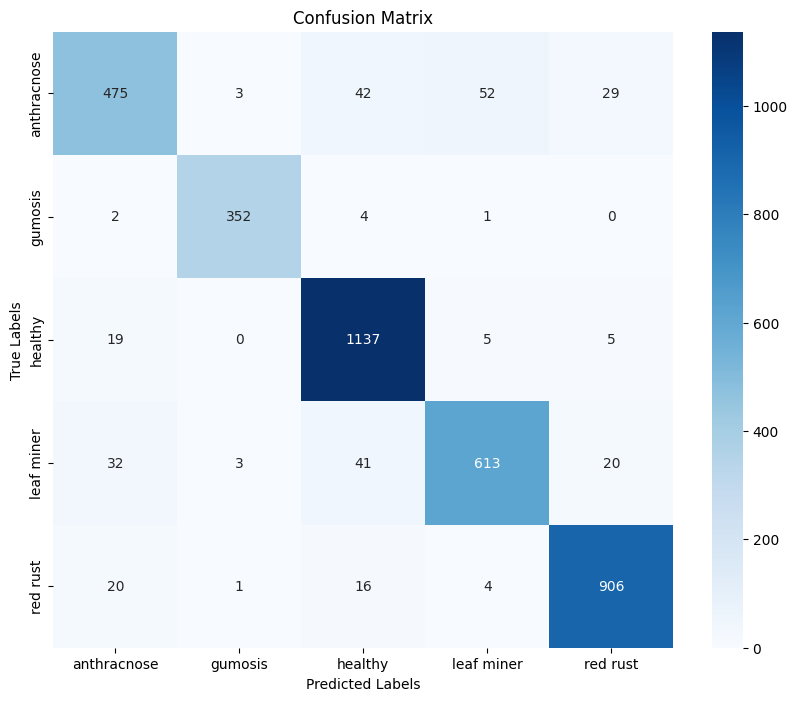

In [ ]:
# evaluate untuned XGBoost model on validation set
start_time = time.time()
untuned_xgb_model.set_params(predictor='cpu_predictor') # switch to CPU predictor
untuned_xgb_predictions = untuned_xgb_model.predict(fused_val_features)
untuned_xgb_accuracy = accuracy_score(val_labels_indices, untuned_xgb_predictions)
untuned_xgb_precision = precision_score(val_labels_indices, untuned_xgb_predictions, average='weighted')
untuned_xgb_recall = recall_score(val_labels_indices, untuned_xgb_predictions, average='weighted')
untuned_xgb_f1 = f1_score(val_labels_indices, untuned_xgb_predictions, average='weighted')
untuned_xgb_roc_auc = roc_auc_score(val_labels_indices, untuned_xgb_model.predict_proba(fused_val_features), multi_class='ovr')

# compute per-class fprs
fprs = []
for i in range(num_classes):
    y_true_i = (val_labels_indices == i).astype(int)
    y_pred_i = (untuned_xgb_predictions == i).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true_i, y_pred_i).ravel()
    fpr_i = fp / (fp + tn) if (fp + tn) > 0 else 0.0
    fprs.append(fpr_i)

# Macro‑average FPR
untuned_xgb_fpr = np.mean(fprs)

# Print results
print(f"Untuned XGBoost Accuracy: {untuned_xgb_accuracy:.4f}")
print(f"Untuned XGBoost Precision: {untuned_xgb_precision:.4f}")
print(f"Untuned XGBoost Recall: {untuned_xgb_recall:.4f}")
print(f"Untuned XGBoost F1-Score: {untuned_xgb_f1:.4f}")
print(f"Untuned XGBoost ROC AUC: {untuned_xgb_roc_auc:.4f}")
print(f"Untuned XGBoost FPR: {untuned_xgb_fpr:.4f}")
print("Untuned XGBoost Classification Report:")
print(classification_report(val_labels_indices, untuned_xgb_predictions, target_names=class_names))
end_time = time.time()
print(f"Evaluation time: {end_time - start_time:.2f} seconds")

# add evaluation metrics to results
results['Accuracy'].append(round(untuned_xgb_accuracy, 2))
results['F1_Score'].append(round(untuned_xgb_f1, 2))
results['Precision'].append(round(untuned_xgb_precision, 2))
results['Recall/TPR'].append(round(untuned_xgb_recall, 2))
results['ROC_AUC'].append(round(untuned_xgb_roc_auc, 2))
results['FPR'].append(round(untuned_xgb_fpr, 2))
results['Validation Time'].append(round(end_time - start_time, 2))

# Generate confusion matrix
cm = confusion_matrix(val_labels_indices, untuned_xgb_predictions)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

In [15]:
# XGBoost Hyperparameter Tuning with BOHB
def objective(trial):
    # Define hyperparameters
    n_estimators = trial.suggest_int('n_estimators', 100, 300, step=50)
    learning_rate = trial.suggest_float('learning_rate', 0.0001, 1, log=True)
    max_depth = trial.suggest_int('max_depth', 3, 20, step=1)
    subsample = trial.suggest_float('subsample', 0.2, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.2, 1.0)

    # Create XGBoost model
    xgb_model = XGBClassifier(n_estimators=n_estimators, 
                            learning_rate=learning_rate, 
                            max_depth=max_depth,
                            subsample=subsample, 
                            colsample_bytree=colsample_bytree, 
                            objective='multi:softmax',
                            num_class=num_classes, 
                            random_state=seed)

    # Train XGBoost model
    xgb_model.fit(fused_train_features, 
                train_labels_indices)
    
    # Evaluate XGBoost model
    y_pred = xgb_model.predict(fused_val_features)
    accuracy = accuracy_score(val_labels_indices, y_pred)
    
    # return accuracy for bohb
    return accuracy

# Define the number of trials to run
NUM_TRIALS = 10

# create study
study = optuna.create_study(direction="maximize",
                            sampler=optuna.samplers.TPESampler(seed=seed),
                            pruner=optuna.pruners.HyperbandPruner(),
                            study_name="xgboost_hyperparameter tunning",
                            load_if_exists=True)

# optimize best parameters
start_time = time.time()
study.optimize(objective, n_trials=NUM_TRIALS)
end_time = time.time()
print(f"Tuning time: {end_time - start_time:.2f} seconds")

# Get the best trial
best_trial = study.best_trial
print("\n--- Best Trial ---")
print(f"Value (Accuracy): {best_trial.value:.4f}")
print("Params: ")
for key, value in best_trial.params.items():
    print(f"    {key}: {value}")

# save study
joblib.dump(study, f"{LOCAL_DIR}/xgboost_study.pkl")

[I 2025-06-17 13:54:24,622] A new study created in memory with name: xgboost_hyperparameter tunning
[I 2025-06-17 13:56:49,591] Trial 0 finished with value: 0.9177683765203596 and parameters: {'n_estimators': 150, 'learning_rate': 0.6351221010640696, 'max_depth': 16, 'subsample': 0.6789267873576292, 'colsample_bytree': 0.3248149123539492}. Best is trial 0 with value: 0.9177683765203596.
[I 2025-06-17 14:10:30,362] Trial 1 finished with value: 0.8730830248545743 and parameters: {'n_estimators': 100, 'learning_rate': 0.0001707396743152812, 'max_depth': 18, 'subsample': 0.6808920093945671, 'colsample_bytree': 0.7664580622368364}. Best is trial 0 with value: 0.9177683765203596.
[I 2025-06-17 14:12:23,770] Trial 2 finished with value: 0.891062929666843 and parameters: {'n_estimators': 100, 'learning_rate': 0.7579479953348001, 'max_depth': 17, 'subsample': 0.36987128854262097, 'colsample_bytree': 0.3454599737656805}. Best is trial 0 with value: 0.9177683765203596.
[W 2025-06-17 14:13:28,337]

KeyboardInterrupt: 